In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/consume-complaints-dataset-fo-nlp/complaints_processed.csv


In [2]:
!git clone https://github.com/victoriamuinde07/NPL-Customer-Complaint-Project.git

Cloning into 'NPL-Customer-Complaint-Project'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 8.47 KiB | 2.82 MiB/s, done.
Resolving deltas: 100% (3/3), done.


### Bank Customer Complaints Classification

### Executive Summary.
This project leverages Natural Language Processing(NLP) to streamline customer complaint classification,aiming to reduce the time and complexity customers face when submitting complaints.By implementing an NLP model that automatically categorizes complaints based on content,the system eliminates the need for customers to navigate through numerous questions or options.The project's primary goals are to minimize the time spent on logging complaints and to enhance user experience with a simple,intuitive interface.

To achieve these goals,the project trained and evaluated various machine learning models,including Multinomial Naive Bayes,Support Vector Machine(SVM),Logistic Regression,Random Forest,and an ensembe model(ExtraTrees),before training and selecting a transformer-based model,BERT.The BERT model excelled in handling language tasks,achieving a Macro F1-score of 0.85,weighted F1-score of 0.89,and an accuracy of 89%,showing strong performance across all complaint categories.The focus on Macro F1-score ensured balanced classification

### Data Exploration

In [3]:
#importing necessary libraries.
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier

from imblearn.over_sampling import SMOTE
import joblib





In [4]:
df = pd.read_csv('/kaggle/input/consume-complaints-dataset-fo-nlp/complaints_processed.csv')
df.head(20)

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...
5,5,credit_reporting,payment history missing credit report made mis...
6,6,credit_reporting,va date complaint experian credit bureau invol...
7,7,credit_reporting,account reported abbreviated name full name se...
8,8,credit_reporting,account reported abbreviated name full name se...
9,9,credit_reporting,usdoexxxx account reported abbreviated name fu...


In [5]:
# Displaying basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


The dataset has 162421 entries and three columns.
Unnamed:0 Appears to be an index column and can be ignored or removed.
Product-Contains the complaint category(target variable) with values like credit_card,retail_banking,credit_reporting etc.
#### There are 10 missing entries in the narrative column

In [6]:
# dropping the unnecessary 'Unnamed: 0' column.
df = df.drop(columns=['Unnamed: 0'])
# dropping rows with missing values in the narrative column
df = df.dropna(subset=['narrative'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162411 entries, 0 to 162420
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    162411 non-null  object
 1   narrative  162411 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


In [7]:
#checking for duplicate rows on 'product','narrative'
duplicates = df.duplicated(subset=['product','narrative']).sum()
duplicates

37735

There are 37,735 duplicate entries in the dataset based on product and narrative columns.However,I'll keep them since during model selection and training,I noted that removing the duplicates would negatively impact our best model performance.

In [8]:
# checking the distribution of the 'product' categories
product_dist = df['product'].value_counts()
product_dist

product
credit_reporting       91172
debt_collection        23148
mortgages_and_loans    18990
credit_card            15566
retail_banking         13535
Name: count, dtype: int64

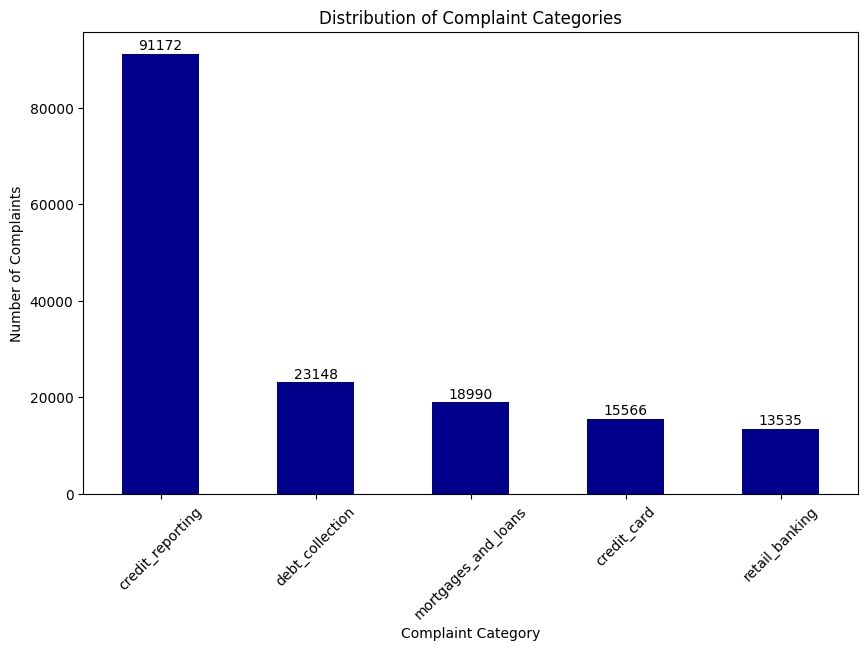

In [9]:
# plotting the distribution of complaint categories.
plt.figure(figsize=(10,6))
ax = product_dist.plot(kind='bar',color='darkblue')
plt.title('Distribution of Complaint Categories')
plt.xlabel('Complaint Category')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)

#adding count on top of each bar.
for i,count in enumerate(product_dist):
    ax.text(i,count + 200,str(count),ha='center',va='bottom')
plt.show()

Unnecessary Unnamed: 0 column dropped and missing values in narrative column handled